name: 241016_data_analysis \
date: 10/16/2024 \
version: 1.1 \
github root: #11 \
author: Justin Sankey, Johanna Ganglbauer \

**description**: Takes raw liquit chromatography mass spectroscopy (LCMS) data (exported table from SCIEX Analyst Software), computes recovery rates, method detection limits, and ratios of default channel to MS TOF channel. Generates plots and writes results to excel and creates long format table (.csv) for data publications.

**what needs to be implemented**:
*   JG: allow seperate recovery filters for separate compounds
*   JG: automatically create list of chemicals including precursor mass / child mass and retention time from data
*   ...
*   **feel free to add your thoughts!**

**contact/help/complaints:** johanna.ganglbauer@uri.edu

# Specifying Inputs - Loading files and packages
Google colab is a cloud service, so it has no access to the files on your local computer, but you can either upload files manually or connect the google colab to your google drive. To understand the filesystem on the cloud **click on the folder symbol on the left bar**.\
To connect to your google drive run the code cell below. You will find your drive in the **content** folder. If you do not want to aim for this option you can also upload your input files to the **content/sample_data** folder and use it from there.

Depending on the server utilization it may take a while to load the preview of your files especially when connected to the google drive.

In addition, the block below will load all python packages needed for the following analysis.

In [1]:
# connect google colab with your google drive
# from google.colab import drive
# drive.mount('/content/drive')

# import all needed packages
import os
import numpy as np
import seaborn as sns
from openpyxl import load_workbook
from openpyxl.drawing.image import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# import pandas and suppress warnings
import pandas as pd
pd.options.mode.chained_assignment = None

**Enter in your input filepaths:** \
(1) raw_data_filepaths is a list of files pointing to the exported table from the Sciex Analyst Software you want to analyze. Each file representing results from the core method must end with '_core', each file representing results from the extended method must end with '_extended'. \
(2) idl_2024_filepath is a .csv file containing instrumentation detection limits (IDLs) \
(3) idl_iql_filepath is another .csv file containing instrumentation detection limits for more PFAS components \
(4) processed filepath indicates location and file prefix where your results should be saved to \
(5) plot directory indictes location where your plots should be saved to. \

for (2) and (3) default files available on the Lohmann drive under example_input.

Once you connected google colab to the drive or uploaded your files to the server file system the best way to get your input filepaths is to search the files you want to use in the filesystem of google colab (click folder symbol on the left bar), right click on the file and choose "copy filepath". Then you can directly insert the related filepath to your Code.


In [2]:
# raw data upload file path
raw_filepaths = [
    r'example_data_raw/test_data_core.txt',
    r'example_data_raw/test_data_extended.txt',
]

# file paths for IDL and IQL data - not meant to be adopted
idl_filepath = r'example_data_raw/IDL_2024.csv'

# processed data output excel file path
processed_filepath =r'example_data_processed/test_data'

# directory to save plots to
plot_directory = r'example_figures'

**Enter in your parameters:**

(1) Change what you deem to be an acceptable recovery range. \
(2) Indicate the maximal allowed percentage deviation between MS TOF channel and MS/MS channel. \
(3) Provide a default value for the instrumentation detection limit (IDL) in case the component is not listed in the csv. \
(4) Indicate which samples you want to use to calculate MDL values. You can only use terms which are used in the "Sample Comment" column of your input data. \
(5) Introduce the hard facts about your sample. \

A common source of confusion is the fact that the actual concentration of targeted compounds in the LCMS analysis is calculated in ng/sample by the developed method.\
To convert the results to ng/l (water samples) or ng/g (tissue, sediment, etc.) you need to indicate the 'non extracted sample quantity'. \
To compare the results to the calibration data you need to indicate the volume of your extracted sample. (it is commonly 0.5 ml).

In [3]:
# color-coding and range for recoveries table
allowed_recovery_min = 0.5
allowed_recovery_max = 1.5

# threshold for acceptance of absolute percentage difference between default channel and TOF MS channel
allowed_channel_deviation = 30

# idl default value
idl_unknown = 1e-3

# samples used for MDL calculatation - keywords need to be used in "Sample Comment" column of input data
# if you want to use IDLs only, use an empty list.
mdl_selection = [
    'IS Check', 'Process Blank', 'Water Extraction Blank',
]

# hard facts about your sample - to correct compare IPS concentrations and convert the PFAS concentration.
ips_concentration_calibration = 4  # ng/ml
extracted_sample_volume = 0.5  # ml
sample_unit = 'l'  # eiter 'l' for liter or 'g' for gram
nonextracted_sample_quantity = 1 # indicate the weight (if sample_unit is 'g') or volume (if sample unit is 'l') or your non-extracted sample.

The following  code block reads in data and cleans it up.

In [4]:
# Parse inputs
if sample_unit not in ['l', 'g']:
    raise Exception("""Please use either 'g' or 'l' for variable sample_unit. """)

# Ensure file path and folder path exist to write outputs to and create folders, if they do not exist
folder_path = os.path.dirname(processed_filepath)
if folder_path and not os.path.exists(folder_path):
    os.makedirs(folder_path)
processed_filepath_xlsx = processed_filepath + '.xlsx'
processed_filepath_csv = processed_filepath + '.csv'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

# Define columns of input which are needed for further processes:
columns_considered = [
    'Sample Name', 'Sample Index', 'Sample Comment', 'Sample Type',
    'Component Name',  'Component Group Name', 'Component Comment', 'IS Name',
    'Acquisition Date & Time', 'Injection Volume', 'Used',
    'Calculated Concentration', 'Actual Concentration', 'IS Actual Concentration',
    'Reported Recovery', 'IDA Average Response Factor',
    'Area', 'IS Area', 'Area IDA', 'Area IPS',
    'Retention Time', 'IS Retention Time', 'Retention Time Error (%)', 'Retention Time Delta (min)',
    'Start Time', 'IS Start Time', 'End Time', 'IS End Time',
    'Precursor Mass', 'Fragment Mass',
]

# Load input data files and put them all in one dataframe
data = pd.DataFrame()  # initialize empty data frames
component_index = 0  # initialize Component Index
for file in raw_filepaths:
    # read in file
    if file[-4:] == '.csv':
        this_data = pd.read_csv(file, delimiter=',', encoding='utf-8', low_memory=False, header=0,)
    elif file[-4:] == '.txt':
        this_data = pd.read_csv(file, delimiter='\t', encoding='utf-8', low_memory=False, header=0,)
    else:
        print('Raw input file paths must either be .csv or .txt files.')

    # increase component index to remain unique for multiple data frames
    this_data['Component Index'] = this_data['Component Index'] + component_index
    component_index += max(this_data['Component Index'])

    # make sure each sample name ends with Ext for extended method and with Core for core method
    if file[-12:-4] == 'extended':
        mask_names = this_data['Sample Name'].str.endswith('Ext')
        this_data['Sample Name'][~mask_names] = [compound + ' Ext' for compound in this_data['Sample Name'][~mask_names].to_list()]
    elif file[-8:-4] == 'core':
        mask_names = this_data['Sample Name'].str.endswith('Core')
        this_data['Sample Name'][~mask_names] = [compound + ' Core' for compound in this_data['Sample Name'][~mask_names].to_list()]
    else:
        print('If you combine core method and extended method make sure your input file names end with _core and _extended respectively.')

    # append actual dataframe in list (this_data) to huge dataframe (data)
    if data.empty:
        data = this_data[columns_considered]  # initialize data in first step (when data is empty)
    else:
        data = pd.concat([data, this_data[columns_considered]], ignore_index=True)  # append to data

# Clean up 'Calculated Concentration' column - set all strange strings to NaN
data['Calculated Concentration'] = data['Calculated Concentration'].replace(
    {'<1 points': np.nan, '< 0': np.nan, 'no root': np.nan, 'NaN': np.nan}
    ).astype('float')

# Replace 'IPS-13C2_PFOA' values: optional, only when component name occurs
if any(data['Component Name'].isin(['IPS-13C2_PFOA'])):
    data['Component Group Name'] = data['Component Group Name'].replace('IPS-13C2_PFOA', 'IPS-13C4_PFOA')

    # Find rows where 'Component Group Name' is 'IPS-13C4_PFOA' (after replacement)
    mask = data['Component Group Name'] == 'IPS-13C4_PFOA'

    # Iterate through each of these rows and replace area in column
    for idx, row in data[mask].iterrows():
        sample_name = row['Sample Name']

        # Find the corresponding row with 'Component Name' == 'IPS-13C4_PFOA' and the same 'Sample Name'
        matching_row = data[(data['Component Name'] == 'IPS-13C4_PFOA') & (data['Sample Name'] == sample_name)]

        if not matching_row.empty:
            # Update the 'Area IPS' with the value from 'Area' in the matching row
            data.at[idx, 'Area IPS'] = matching_row['Area'].values[0]

# Correct channel names in original data (all of the TOF channels are labelled by _TOF MS, only 2 of them are labeled by only _TOF)
mask_names = data['Component Name'].str.endswith('_TOF')
data['Component Name'][mask_names] = [compound + ' MS' for compound in data['Component Name'][mask_names].to_list()]

# some have an underscore between TOF and MS, this is removed
mask_names = data['Component Name'].str.endswith('_TOF_MS')
data['Component Name'][mask_names] = [compound[:-3] + ' MS' for compound in data['Component Name'][mask_names].to_list()]

# make sample index equal if one sample exist as both "Core Method" and "Extended Method"
sample_names = data['Sample Name'].unique()
# combine indices of Core Method and Extended Method if both are available
detect = 0
index_mapper = {}
for sample_name in sample_names:
    if sample_name[-3:] == 'Ext' and sample_name[:-3] + 'Core' in sample_names:
        sample_indices = data.loc[data['Sample Name'].isin([sample_name, sample_name[:-3] + 'Core']), 'Sample Index'].unique()
        data.loc[data['Sample Index'].isin(sample_indices), 'Sample Index'] = sample_indices[0]
        index_mapper[sample_indices[0]] = sample_name[:-3]
        detect+=1
    elif sample_name[-4:] == 'Core':
        continue
    else:
        print(f'The sample {sample_name} has no related Core Method. Find out if this is a problem.')

# Get the order of components and split it to default channel (MS/MS) and TOF channel.
# If either channel is not available a copy of the other one is used respectively.
if detect > 0:
    first_sample_id = sample_indices[0]
else:
    first_sample_id = data['Sample Index'].value_counts().index[0]  # index of first sample
components_sorted_duplicate = data.loc[data['Sample Index'] == first_sample_id, 'Component Name']  # channel names of first sample
components_sorted_duplicate = components_sorted_duplicate[~components_sorted_duplicate.str.contains('IDA|IPS|13C')].to_list()  # channel names excluding IPS and IDA

# remove duplicates from components_sorted_duplicate
components_sorted = []
[components_sorted.append(x) for x in components_sorted_duplicate if x not in components_sorted]

# initialize and fill lists of sorted components
components_default = []
components_tof = []
skip_index = []
for (index, component) in enumerate(components_sorted):
    if index in skip_index:
        continue
    if '_TOF MS' in component:
        if component[:-7] in components_sorted:
            components_default.append(component[:-7])
            components_tof.append(component)
            skip_index.append(components_sorted.index(component[:-7]))
        else:
            continue
    else:
        components_default.append(component)
        if component + '_TOF MS' in components_sorted:
            components_tof.append(component + '_TOF MS')
            skip_index.append(components_sorted.index(component + '_TOF MS'))
        else:
            components_tof.append(component)

# display settings
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of columns

The sample PFAS QCS0 0ng/ml Ext has no related Core Method. Find out if this is a problem.


The following code block separates data in calibration data, data for mdl calculation (blank data) and quantification data.

In [5]:
# Split data into quantification data, calibration data, and blanks for mdl calculation
calibration_only = data[(data['Sample Type'] == 'Standard')]
quantification_blank = data[(data['Sample Type'] != 'Standard')]

if not quantification_blank.empty:
    # select data for computation of mdl and exclude it from quantification data
    if mdl_selection == []:
        blank_only = None
        quantification_only = quantification_blank
    else:
        blank_selection = quantification_blank['Sample Comment'].str.contains('|'.join(mdl_selection))
        if sum(blank_selection) == 0:
            (f'Be careful, no samples have been collected for the MDL calculation because {mdl_selection} is not a Sample Comment.')
            print(f'If you do not select blank set variable mdl_selection to [].')
        if sum(blank_selection) == len(quantification_blank):
            print(f'Be careful, all samples have been collected for the MDL calculation.')
            print(f'If this is not what you want reset the variable mdl_selection in the top block.')
        blank_selection.replace({np.nan: False}, inplace=True)
        blank_only = quantification_blank[blank_selection]
        quantification_only = quantification_blank[~blank_selection]

# Recovery Rates
To avoid misunderstandings, in the following two abbreviations are extensively used:
- IDA: isotope dilution analysis, also known as SS=surrogate standard or EIS=extracted internal standard
- IPS: isotope performance standard, also known as IS=injection standard or NIS=non-extracted internal standard

**The following two blocks calculate response factors from calibration data:**\
ratio of (i) calculated area of IDA * **actual concentration of IPS** and (ii) calculated area of IPS * actual concentration of IDA. \
The data is saved to an excel file and a boxplot of response factors is created.

Note: The response factor calculation within sciex uses the ratio of (i) calculated area of IDA and (ii) calculated area of IPS * actual concentration of IDA. \
As the concentration of IPS is missing in the calculation, the response factors deviate by a factor of 4, which is the actual concentration of IPS in the calibration data.

In [6]:
# define funtion which calculates the IDA IPS ratio.
# challenge - search right IPS row indicated in the Component Group Name of IDA.
def calculate_ida_ips_ratio(data: pd.DataFrame, column_name:str, ) -> pd.DataFrame:
    """Calculates IDA area times IPS concentration divided by IPS area times IDA concentration and save the results in the indicated column.

    :param data: Entire data junk (including all rows and the following columns:
    Component Name, Sample Index, Component Group Name, Actual Concentration, Area, and IDA Average Response Factor
    :type data: pd.DataFrame
    :param column_name: name of column, the calculated ratio should be saved to
    :type column_name: str
    :return: Data junk only containing IDA rows with the corresponding ratio saved to new column
    :rtype: pd.DataFrame
    """
    data_only_ida = data[data['Component Name'].str.contains('IDA')]
    data_only_ida.loc[:,f'{column_name}'] = [np.nan] * len(data_only_ida)
    data_only_ida.loc[:,'IPS Area'] = [np.nan] * len(data_only_ida)
    data_only_ida.loc[:,'IPS Concentration'] = [np.nan] * len(data_only_ida)

    # calculate recovery rate for every component, end every sample
    for row_index in data_only_ida.index:
        sample_index = data_only_ida.loc[row_index, 'Sample Index']
        ips_channel_name = data_only_ida.loc[row_index, 'Component Group Name']

        sample_name = data_only_ida.loc[row_index, 'Sample Name']
        corresponding_ips_area_row = data[(
            (data['Sample Index'] == sample_index) &
            (data['Component Name'] == ips_channel_name) &
            (data['Sample Name'] == sample_name)
            )]
        data_only_ida.loc[row_index, 'IPS Area'] = corresponding_ips_area_row['Area'].iloc[0]
        data_only_ida.loc[row_index, 'IPS Concentration'] = corresponding_ips_area_row['Actual Concentration'].iloc[0]
        data_only_ida.loc[row_index, f'{column_name}'] = \
            (data_only_ida.loc[row_index, 'Area'] * corresponding_ips_area_row['Actual Concentration'].iloc[0]) \
            / (corresponding_ips_area_row['Area'].iloc[0] * data_only_ida.loc[row_index, 'Actual Concentration'])
    return data_only_ida

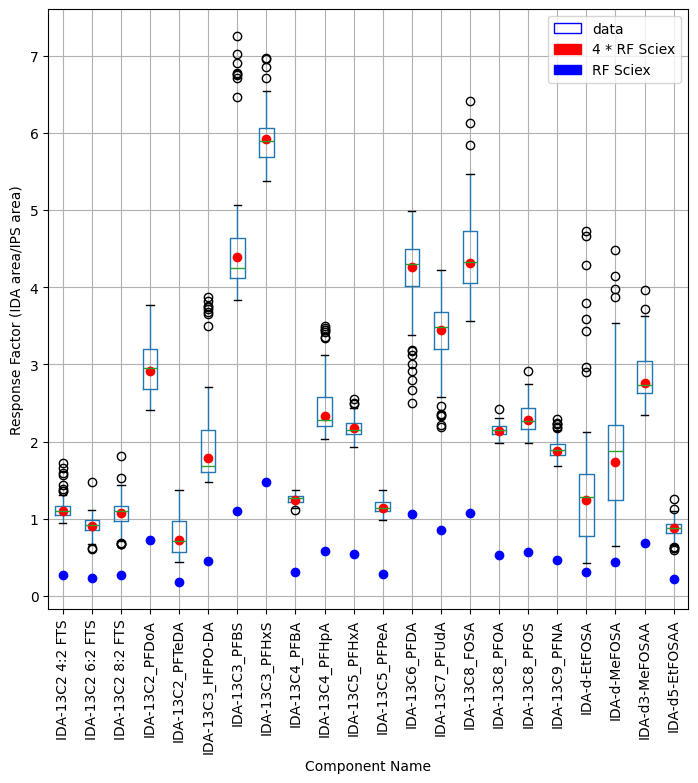

In [7]:
# Extract values of IDAs and IPS
# Save basic sample information as well as areas of intensity peak, actual concentration and Component Group Name.
# The 'Component Group Name' is useful to assoiciate the right IPS to each IDA.

# calucluate IDA IPS ratio to compute response factors with calibration data
calibration_only_ida = calculate_ida_ips_ratio(
    data=calibration_only, column_name='Response Factor from Scratch',
    )

# create data frame with this response factor calculation (from scratch), the standard deviation and the original values evaluated by Sciex,
response_factor = calibration_only_ida.groupby('Component Name', as_index=False)['Response Factor from Scratch'].mean()
response_factor['Response Factor Std'] = calibration_only_ida.groupby('Component Name')['Response Factor from Scratch'].std().to_list()
response_factor['Response Factor Sciex'] = calibration_only_ida.groupby('Component Name')['IDA Average Response Factor'].mean().to_list()
response_factor.rename(columns={'Response Factor from Scratch': 'Response Factor Mean'}, inplace=True)
response_factor.index = response_factor['Component Name']
response_factor.drop(columns=['Component Name'], inplace=True)

# write response factor to excel file
with pd.ExcelWriter(processed_filepath_xlsx, engine='openpyxl') as writer:
    response_factor.to_excel(writer, sheet_name='Response Factor')

# create and save response factor box plots
image_path = os.path.join(plot_directory, 'response_factors.png')
fig, ax = plt.subplots(figsize=(8, 8))
calibration_only_ida.boxplot(column='Response Factor from Scratch', by='Component Name', ax=ax,)
ax.plot([np.nan] + (response_factor['Response Factor Sciex'] * 4).to_list(), color='red', linestyle='', marker="o",)
ax.plot([np.nan] + (response_factor['Response Factor Sciex']).to_list(), color='blue', linestyle='', marker="o",)
fig.suptitle('')
ax.set_title('')
plt.ylabel('Response Factor (IDA area/IPS area)')
plt.xticks(rotation=90)
box_patch = mpatches.Patch(color='blue', fill=False, label='data')
blue_patch = mpatches.Patch(color='blue', label='RF Sciex')
red_patch = mpatches.Patch(color='red', label='4 * RF Sciex')
plt.legend(handles=[box_patch, red_patch, blue_patch])
plt.savefig(image_path, bbox_inches='tight')
plt.show()

# save response factor box plot to excel file
workbook = load_workbook(processed_filepath_xlsx)
plot_sheet = workbook.create_sheet('Details RF')

img = Image(os.path.join(plot_directory, 'response_factors.png'))

cell_position = plot_sheet.cell(row=1, column=1).coordinate
plot_sheet.add_image(img, cell_position)

workbook.save(processed_filepath_xlsx)

The following block is useful to detect and correct wrong information about the amount of IPS added to the samples. \
The ratio of mean IPS area in the samples and mean IPS area in the calibration data is a good indicator.

If the IPS areas are in the same range for calibration and quantification, also the added IPS concentration should be in the same range. \
If the IPS areas of your quantification is twice as much as in the calibration, also the added IPS concentration should be twice as musch.

**Source of confusion:**
The IPS concentration in the calibration data is given per milli liter.\
The IPS concentration in your quantification data is given per sample. When you have a volume of 0.5 ml for your extracted sample the IPS concentration in the quantification will be twice as high.

Here, the IPS concentration in your sample is converted from concentration per sample to concentration per ml to have a fair comparison to the calibration data. \
The data indicated in 'Actual Concentration' Column is usually given per sample - it is converted by dividing through the volume of your extracted samples.

After checking the graph, make sure you inputed the amount of standard you added in the SCIEX software correctly.

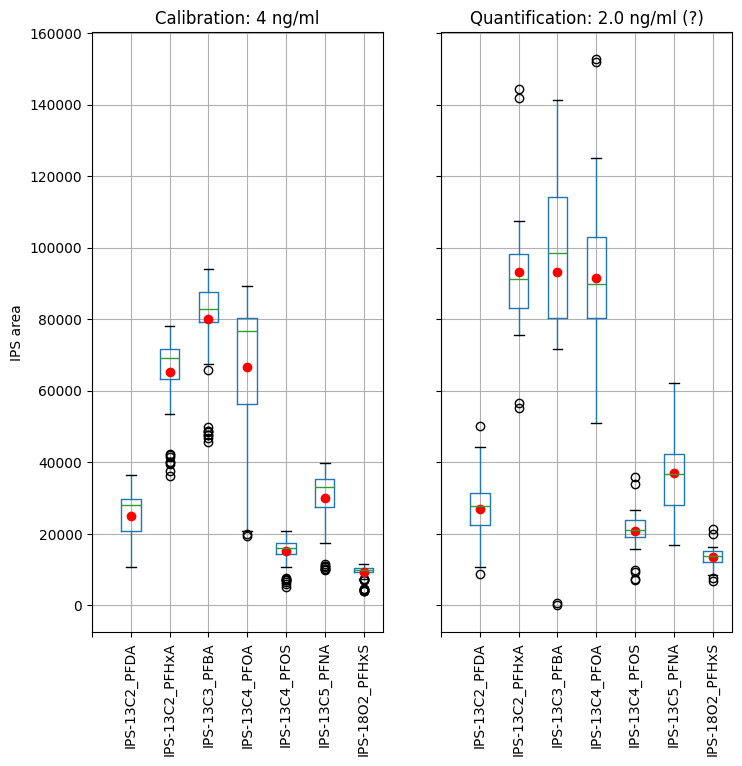

In [8]:
# Calculate IPS average area per compound in calibration data and plot it
calibration_only_ips = calibration_only[calibration_only['Component Name'].str.contains('IPS')]
quantification_blank_only_ips = quantification_blank[quantification_blank['Component Name'].str.contains('IPS')]

# evaluate mean per component
calibration_ips_area_averages = calibration_only_ips.groupby('Component Name')['Area'].mean()
quantification_blank_ips_area_averages = quantification_blank_only_ips.groupby('Component Name')['Area'].mean()

# evaluate IPS concentration in quantification
ips_concentration = quantification_blank_only_ips['Actual Concentration'].mean() / extracted_sample_volume

# create plot for comparison
image_path = os.path.join(plot_directory, 'ips_areas.png')
fig, ax = plt.subplots(ncols=2, figsize=(8, 8), sharey=True)
calibration_only_ips.boxplot(column='Area', by='Component Name', ax=ax[0])
ax[0].plot([np.nan] + calibration_ips_area_averages.to_list(), color='red', linestyle='', marker="o", label='calibration average')
quantification_blank_only_ips.boxplot(column='Area', by='Component Name', ax=ax[1])
ax[1].plot([np.nan] + quantification_blank_ips_area_averages.to_list(), color='red', linestyle='', marker="o", label='quantification average')
fig.suptitle('')
ax[0].set_title('Calibration: 4 ng/ml')
ax[1].set_title(f'Quantification: {ips_concentration} ng/ml (?)')
ax[0].set_xticks(
    ticks=range(len(calibration_ips_area_averages) + 1),
    labels=[''] + calibration_ips_area_averages.index.to_list(), rotation=90
    )
ax[1].set_xticks(
    ticks=range(len(quantification_blank_ips_area_averages) + 1),
    labels=[''] + quantification_blank_ips_area_averages.index.to_list(), rotation=90
    )
ax[0].set_ylabel('IPS area')
[this_ax.set_xlabel('') for this_ax in ax]
plt.savefig(image_path, bbox_inches='tight')
plt.show()

# save IPS area comparison plot to excel file
workbook = load_workbook(processed_filepath_xlsx)
plot_sheet = workbook.create_sheet('Details IPS concentration')

img = Image(os.path.join(plot_directory, 'ips_areas.png'))

cell_position = plot_sheet.cell(row=1, column=1).coordinate
plot_sheet.add_image(img, cell_position)

workbook.save(processed_filepath_xlsx)

The following block calculates recovery rates for each IDA compound in each sample.
$$
recovery~rate = \frac{\frac{area_{IDA~sample}~\cdot~concentration_{IPS~sample}}{area_{IPS~sample}~\cdot~concentration_{IDA~sample}}}{average(\frac{area_{IDA~calibration}~\cdot~concentration_{IPS~calibration}}{area_{IPS~calibration}~\cdot~concentration_{IDA~calibration}})} = \frac{ratio}{response~factor}
$$

The recovery rates are illustrated for all samples and all IDAs to enable a quick visual sanity check.

Recovery rate computed within the SCIEX software is not normalized by concentration. So the recovery rate calculated by SCIEX reads:
$$
recovery~rate = \frac{\frac{area_{IDA~sample}}{area_{IPS~sample}}}{average(\frac{area_{IDA~calibration}}{area_{IPS~calibration}})}
$$

The uncertainty of the recovery rate is indicate by a maximum error method - for now, you can just ignore this part...
$$
\Delta recovery~rate = \Delta response~factor \cdot \frac{ratio}{response~factor^{2}} + \Delta ratio \cdot \frac{1}{response~factor}
$$

In [9]:
# color code percentage deviation
def recovery_color_map(val):
    if val is np.nan:
        return
    if allowed_recovery_min <= val <= allowed_recovery_max:
        return 'background-color: green'
    elif val < allowed_recovery_min or val > allowed_recovery_max:
        return 'background-color: red'
    
# color code percentage deviation
def deviation_color_map(val):
    if val is np.nan:
        return
    if allowed_channel_deviation * (-1) <= val <= allowed_channel_deviation:
        return 'background-color: green'
    elif val < allowed_channel_deviation * (-1) or val > allowed_channel_deviation:
        return 'background-color: red'


C:\Users\johanna.ganglbauer\AppData\Local\Temp\ipykernel_29532\3496036734.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


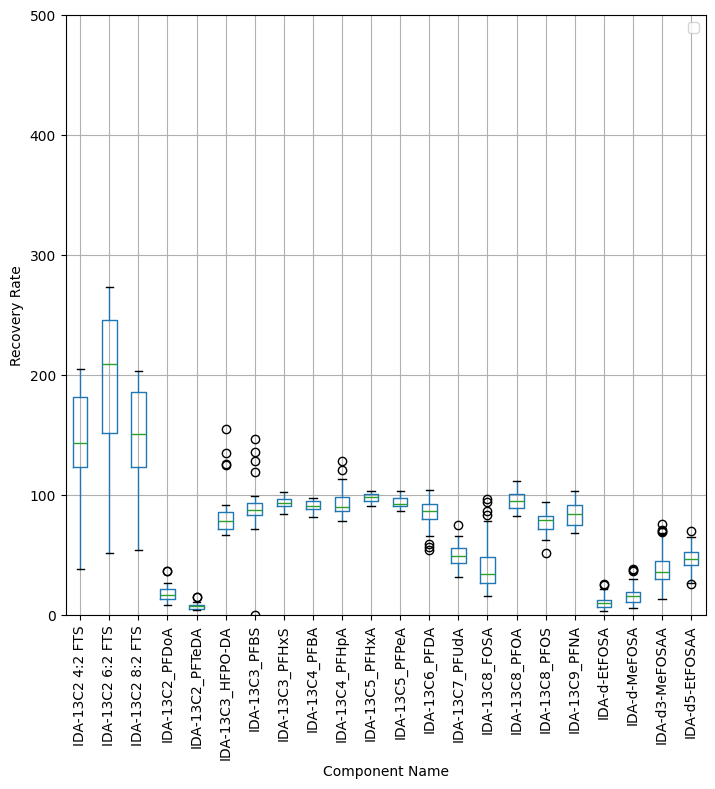

C:\Users\johanna.ganglbauer\AppData\Local\Temp\ipykernel_29532\3496036734.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(plot_data)) # initialize colours


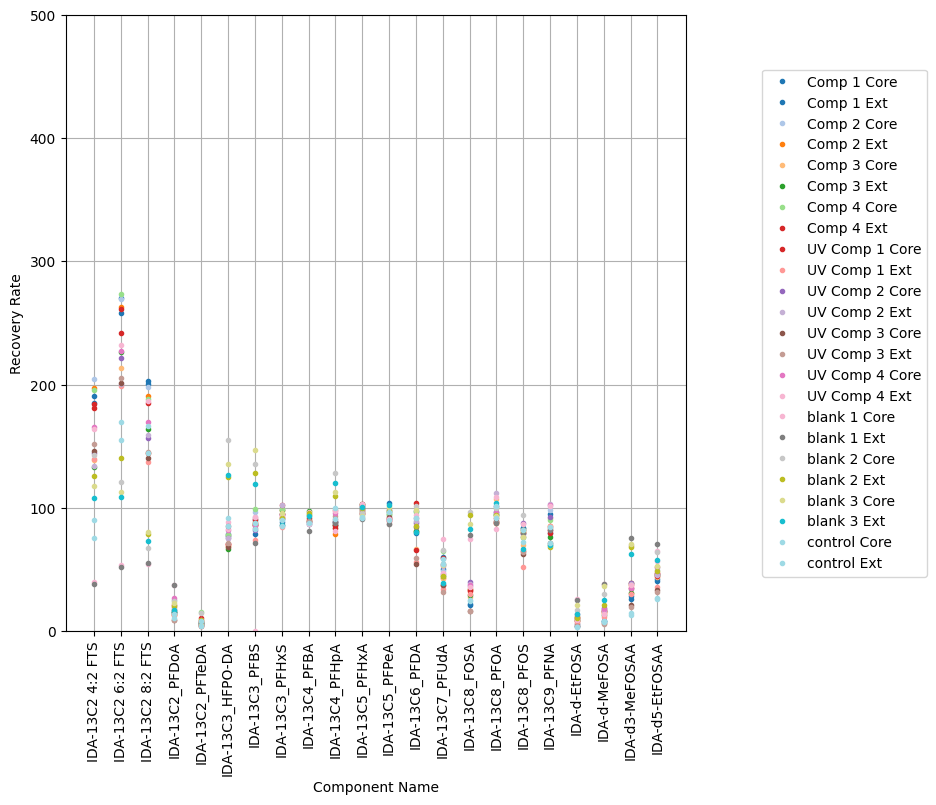

In [10]:
# Select ida rows from quantification data and calculate ida ips ratio
# function is defined in previous block
quantification_ida = calculate_ida_ips_ratio(
    data=quantification_only, column_name="IDA-IPS Ratio",
    )

# Assign right response factor to each IDA
quantification_ida.loc[:, 'Response Factor Mean'] = [np.nan] * len(quantification_ida)
quantification_ida.loc[:, 'Response Factor Std'] = [np.nan] * len(quantification_ida)

for component in response_factor.index:
    quantification_ida.loc[quantification_ida['Component Name'] == component, 'Response Factor Mean'] = response_factor.loc[component, 'Response Factor Mean']
    quantification_ida.loc[quantification_ida['Component Name'] == component, 'Response Factor Std'] = response_factor.loc[component, 'Response Factor Std']

# Calculate recovery rate and its related uncertainty
quantification_ida.loc[:, 'Recovery Rate'] = quantification_ida.loc[:, 'IDA-IPS Ratio'] / quantification_ida.loc[:, 'Response Factor Mean']
quantification_ida.loc[:, 'Recovery Rate Uncertainty 1'] = quantification_ida.loc[:,'Response Factor Std'] * quantification_ida.loc[:,'IDA-IPS Ratio'] \
     / (quantification_ida.loc[:, 'Response Factor Mean'] * quantification_ida.loc[:, 'Response Factor Mean'])

# Put computed recovery rate, and recovery rate from the sciex software in pivot table
recovery = quantification_ida.pivot_table(
    index=('Sample Index',), columns='Component Name', values='Recovery Rate', aggfunc='mean', dropna=False,
    )
recovery.rename(index=index_mapper, inplace=True)

recovery_sciex = quantification_ida.pivot_table(
    index=('Sample Index',), columns='Component Name', values='Reported Recovery', aggfunc='mean', dropna=False,
    ) / 100
recovery_sciex.rename(index=index_mapper, inplace=True)

# Write recovery rate to excel file
with pd.ExcelWriter(processed_filepath_xlsx, engine='openpyxl', mode='a') as writer:
    recovery.style.map(recovery_color_map).to_excel(writer, sheet_name='Recovery Rate')
    recovery_sciex.style.map(recovery_color_map).to_excel(writer, sheet_name='Sciex Recovery Rate')

# Multiply recovery rate by 100
quantification_ida["Recovery Rate"] = 100 * quantification_ida["Recovery Rate"]

# Box plot for recovery rates
image_path = os.path.join(plot_directory, 'recovery_rates_box.png')
fig, ax = plt.subplots(figsize=(8, 8))
quantification_ida.boxplot(column='Recovery Rate', by='Component Name', ax=ax,)
ax.set_ylim([0,500])
fig.suptitle('')
ax.set_title('')
plt.ylabel('Recovery Rate')
plt.xticks(rotation=90)
plt.legend()
plt.savefig(image_path, bbox_inches='tight')
plt.show()

# plot data as points for recovery rates:
plot_data = quantification_ida.groupby('Sample Name')  # group data for plotting
cmap = plt.cm.get_cmap('tab20', len(plot_data)) # initialize colours
image_path = os.path.join(plot_directory, 'recovery_rates.png')  # set path for figure

fig, ax = plt.subplots(figsize=(8, 8))
for index, (title, group) in enumerate(plot_data):
    group.set_index(group['Component Name'], inplace=True)
    group.sort_index(inplace=True)
    group.drop_duplicates(keep='first', inplace=True)
    group.plot(
        y='Recovery Rate', ax=ax, marker='.', linestyle='None', label=title, grid=True, color = cmap(index),
    )
ax.set_ylim([0,500])
fig.suptitle('')
ax.set_xticks(range(len(group)))
ax.set_xticklabels(group['Component Name'], rotation=90)
ax.set_title('')
plt.xticks(rotation=90)
plt.ylabel('Recovery Rate')
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.savefig(image_path, bbox_inches='tight')
plt.show()

# save recovery rate plot to excel file
workbook = load_workbook(processed_filepath_xlsx)
plot_sheet = workbook.create_sheet('Details Recovery Rates')

img1 = Image(os.path.join(plot_directory, 'recovery_rates_box.png'))
img1.anchor = 'A1'
plot_sheet.column_dimensions['A'].width = img1.width / 6
plot_sheet.row_dimensions[1].height = img.height
plot_sheet.add_image(img1)

img2 = Image(os.path.join(plot_directory, 'recovery_rates.png'))
img2.anchor = 'B1'
plot_sheet.column_dimensions['B'].width = img2.width / 6
plot_sheet.add_image(img2)

workbook.save(processed_filepath_xlsx)

In the following code block the right recovery rate is assigned to each PFAS. Each PFAS component has a corresponding IDA - the recovery rate is deduced from the recovery rate of the corresponding IDA.
The assignment works for each sample by using the 'IS Name' column which provides information on which IDA standard is associated to which PFAS.\

When both core method and extended method are combine, some of the PFAS components may be measured twice - in that case the average of the recovery rates and the average of the concentrations is used.

In [11]:
# Initialize data frame for following assignments, select only needed columns and use reasonable naming.
selected_columns = [
    'Sample Name', 'Sample Index', 'Acquisition Date & Time', 'Component Name', 'IS Name', 'Calculated Concentration', 'Area',
    ]
quantification_pfas_default = quantification_only[selected_columns]
quantification_pfas_default.rename(columns={'IS Name': 'IDA Name'}, inplace=True)

# Get only PFAS default channels
quantification_pfas_default = quantification_pfas_default[quantification_pfas_default['Component Name'].isin(components_default)]

# Assign right recovery rate and uncertainty to each PFAS compound
quantification_pfas_default.loc[:,'IDA Area'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'IDA Concentration'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'IPS Area'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'IPS Concentration'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'IPS Name'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'Recovery Rate'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'Recovery Rate Uncertainty 1'] = [np.nan] * len(quantification_pfas_default)
quantification_pfas_default.loc[:,'Recovery Rate Sciex'] = [np.nan] * len(quantification_pfas_default)
for row_index in quantification_pfas_default.index:
    sample_index = quantification_pfas_default.loc[row_index, 'Sample Index']
    ida_channel_name = quantification_pfas_default.loc[row_index, 'IDA Name']
    if ida_channel_name in quantification_ida['Component Name'].to_list():
        recovery_row = quantification_ida[(
            (quantification_ida['Component Name'] == ida_channel_name) &
            (quantification_ida['Sample Index'] == sample_index)
        )]
        quantification_pfas_default.loc[row_index,'IDA Area'] = recovery_row.loc[:,'Area'].mean()
        quantification_pfas_default.loc[row_index,'IDA Concentration'] = recovery_row.loc[:,'Actual Concentration'].mean()
        quantification_pfas_default.loc[row_index,'IPS Area'] = recovery_row.loc[:,'IPS Area'].mean()
        quantification_pfas_default.loc[row_index,'IPS Concentration'] = recovery_row.loc[:,'IPS Concentration'].mean()
        quantification_pfas_default.loc[row_index, 'IPS Name'] = \
            recovery_row.loc[:,'Component Group Name'].to_list()[0]
        quantification_pfas_default.loc[row_index, 'Recovery Rate'] = \
            recovery_row.loc[:,'Recovery Rate'].mean()
        quantification_pfas_default.loc[row_index, 'Recovery Rate Uncertainty 1'] = \
            (recovery_row.loc[:,'Recovery Rate Uncertainty 1'].round(decimals=3) * 100).mean()
        quantification_pfas_default.loc[row_index, 'Recovery Rate Sciex'] = \
            recovery_row.loc[:,'Reported Recovery'].mean()

    else:
        quantification_pfas_default.loc[row_index,'IDA Area'] = np.nan
        quantification_pfas_default.loc[row_index,'IDA Concentration'] = np.nan
        quantification_pfas_default.loc[row_index,'IPS Area'] = np.nan
        quantification_pfas_default.loc[row_index,'IPS Concentration'] = np.nan
        quantification_pfas_default.loc[row_index, 'IPS Name'] = np.nan
        quantification_pfas_default.loc[row_index, 'Recovery Rate'] = np.nan
        quantification_pfas_default.loc[row_index, 'Recovery Rate Uncertainty 1'] = np.nan
        quantification_pfas_default.loc[row_index, 'Recovery Rate Sciex'] = np.nan

for column in ['Recovery Rate', 'Recovery Rate Uncertainty 1', 'Recovery Rate Sciex']:
    quantification_pfas_default[f'{column}'] = quantification_pfas_default[f'{column}'].round(decimals=1)

# Put computed recovery rate in pivot table
recovery = quantification_pfas_default.pivot_table(
    index=('Sample Index',), columns='Component Name', values='Recovery Rate', aggfunc='first', dropna=False,
    )
recovery.rename(index=index_mapper, inplace=True)
recovery = recovery[components_default]

# Write to excel file
with pd.ExcelWriter(processed_filepath_xlsx, engine='openpyxl', mode='a') as writer:
    recovery.to_excel(writer, sheet_name='Recovery Rate Extended')

# Apply filter to measurements: samples and PFAS components with recovery rates being below the lower threshold or above the upper thresholds will be flagged.
quantification_pfas_default.loc[:,'Poor Recovery'] = ~quantification_pfas_default['Recovery Rate'].between(
    allowed_recovery_min * 100, allowed_recovery_max * 100, inclusive='both',
    )
quantification_pfas_default.loc[quantification_pfas_default['Recovery Rate'].isnull(), 'Poor Recovery'] = False

C:\Users\johanna.ganglbauer\AppData\Local\Temp\ipykernel_29532\65529922.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IPS-13C3_PFBA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  quantification_pfas_default.loc[row_index, 'IPS Name'] = \


# Method Detection Limits
The following block compute method detection limits (MDL) based on average and standard deviation of selected samples (process blanks, etc.). \
The code use instrument detection limits (IDL) for the PFAS compounds not included in the process blanks. \
For some comounds the IDL may not be included in the input files, then the default value is used.\

Moreover, a new column 'Below Detection Threshold' is introduces, which indicates all Calculated Concentration Values of PFAS quantification below the determined detection limits.

In [12]:
# Make empty dataframe if blanks for MDL calculations are not available
mdl = pd.DataFrame(index=components_default)
mdl['Mean Concentration'] = [np.nan] * len(mdl)
mdl['Std Concentration'] = [np.nan] * len(mdl)
mdl['MDL'] = [np.nan] * len(mdl)
mdl['IDL'] = [np.nan] * len(mdl)

if not blank_only.empty:
    blank_only_default = blank_only[blank_only['Component Name'].isin(components_default)]
    # create data frame with average and standard deviation values for MDL calculation and caluclate MDL
    mdl_mean = blank_only_default.groupby('Component Name')['Calculated Concentration'].mean()
    mdl_std = blank_only_default.groupby('Component Name')['Calculated Concentration'].std()
    for (index, value) in mdl_mean.items():
        mdl.loc[index, 'Mean Concentration'] = value
    for (index, value) in mdl_std.items():
        mdl.loc[index, 'Std Concentration'] = value
    mdl['MDL'] = mdl['Mean Concentration'] + 3 * mdl['Std Concentration']

# Load idl values from idl input file
idl = pd.read_csv(idl_filepath, index_col=0, low_memory=False, nrows=1)
idl = idl.drop(columns=['Unnamed: 55'])


# Write each iql value in new column of mdl dataframe
for row_index in mdl.index:
    if row_index in idl.columns:
        mdl.loc[row_index, 'IDL'] = idl[f'{row_index}'].to_list()[0]
    else:
        mdl.loc[row_index, 'IDL'] = idl_unknown
        print(f'No IDL available for {row_index}, default value of 1e-3 is used.')

mdl['Detection Threshold'] = mdl['MDL']
mdl['Detection Threshold'].fillna(mdl.IDL, inplace=True)

# write detection threshold to excel file
with pd.ExcelWriter(processed_filepath_xlsx, engine='openpyxl', mode='a') as writer:
    mdl.to_excel(writer, sheet_name='Detection Threshold')

# include detection threshold to long format table data quantification_pfas_default
# assign right detection thresholds to right rows.
quantification_pfas_default.loc[:, 'Below Detection Threshold'] = [False] * len(quantification_pfas_default)
quantification_pfas_default.loc[:, 'Detection Threshold'] = [np.nan] * len(quantification_pfas_default)
for row_index in quantification_pfas_default.index:
    component_name = quantification_pfas_default.loc[row_index, 'Component Name']
    detection_threshold = mdl.loc[component_name, 'Detection Threshold']
    # print(detection_threshold)
    quantification_pfas_default.loc[row_index, 'Detection Threshold'] = detection_threshold
    if quantification_pfas_default.loc[row_index, 'Calculated Concentration'] < detection_threshold:
        quantification_pfas_default.loc[row_index, 'Below Detection Threshold'] = True

No IDL available for N-TAmP-FHxSA, default value of 1e-3 is used.


C:\Users\johanna.ganglbauer\AppData\Local\Temp\ipykernel_29532\873151736.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mdl['Detection Threshold'].fillna(mdl.IDL, inplace=True)


# Mass Channel Ratios
The following block evaluates ratio of calculated concentration from default channel and _TOF MS channel for all PFAS components and all samples. \

Moreover a column a new column 'Channel Ratio . x' is intrudoced, which indicates all calculated concentration values which deviate more than x % between channels.\

x is the variable 'allowed_channel_deviation' you set in the third code block on top.

In [13]:
# Assign TOF channel to each PFAS and save calculated concentration to new column
quantification_pfas_default.loc[:,'Calculated Concentration TOF'] = [np.nan] * len(quantification_pfas_default)
for row_index in quantification_pfas_default.index:
    sample_index = quantification_pfas_default.loc[row_index, 'Sample Index']
    tof_channel_index = components_default.index(quantification_pfas_default.loc[row_index, 'Component Name'])
    tof_channel_name = components_tof[tof_channel_index]
    tof_channel_row = quantification_only[(
        (quantification_only['Component Name'] == tof_channel_name) &
        (quantification_only['Sample Index'] == sample_index)
    )]
    quantification_pfas_default.loc[row_index, 'Calculated Concentration TOF'] = \
        tof_channel_row.loc[:,'Calculated Concentration'].to_list()[0]

# Calculate average deviation of the channels
quantification_pfas_default['Channel Ratio'] = (
    200 * (quantification_pfas_default['Calculated Concentration'] - quantification_pfas_default['Calculated Concentration TOF']) \
        / (quantification_pfas_default['Calculated Concentration'] + quantification_pfas_default['Calculated Concentration TOF'])
).round(decimals=1)

# Introduce new column where everything below method detection limit is marked
quantification_pfas_default[f'Channel Ratio > {allowed_channel_deviation}'] = abs(quantification_pfas_default['Channel Ratio']) > allowed_channel_deviation

# Create pivot table
channel_ratio = quantification_pfas_default.pivot_table(
    index=('Sample Index',), columns='Component Name', values='Channel Ratio', aggfunc='mean', dropna=False,
)
channel_ratio.rename(index=index_mapper, inplace=True)
channel_ratio = channel_ratio[components_default]

channel_ratio = channel_ratio.style.map(deviation_color_map)

# write to existing excel file
with pd.ExcelWriter(processed_filepath_xlsx, engine='openpyxl', mode='a') as writer:
    channel_ratio.to_excel(writer, sheet_name='Channel Ratio')

# Outputs
The following code block writes final concentration table with all information to excel. It uses concentration values and indicates all values below detection threshold with '< MDL', all channel deviation above x % with '> CR' and all recovery rates below or above the indicated threshold values with 'Poor Recovery'.
In addition, concentration values are converted to ng\g or ng\l respectively.

In [14]:
def flag_values(data: pd.DataFrame, column: str) -> pd.DataFrame:
    """Flags column values (most probably concentrations) with channel ratio, recovery rates and MDLs.

    :param data: data frame containing columns 'Channel Ratio', 'Poor Recovery', and 'Below Detection Threshold',
    as well as the column you indicated.
    :type data: pd.DataFrame
    :param column: Colun name of data frame to be filtered or flagged.
    :type column: str
    :return: Data frame, where the column data is flagged.
    :rtype: pd.DataFrame
    """
    final_table = data[['Sample Name', 'Sample Index', 'Component Name', column]]
    final_table.loc[final_table.index[quantification_pfas_default[f'Channel Ratio > {allowed_channel_deviation}']], column] = '> CR'
    final_table.loc[final_table.index[quantification_pfas_default['Poor Recovery']], column] = 'Poor Recovery'
    final_table.loc[final_table.index[quantification_pfas_default['Below Detection Threshold']], column] = '< MDL'
    return final_table

# Transform concentration to ng/g or ng/l, depending on your sample_unit
quantification_pfas_default[f'Concentration in ng per {sample_unit}'] = quantification_pfas_default['Calculated Concentration'] / nonextracted_sample_quantity

# Flag concentration values with channel ratio, recovery rates and detection threshold.
calculated_concentration = flag_values(data=quantification_pfas_default, column='Calculated Concentration')
calculated_concentration_II = flag_values(data=quantification_pfas_default, column=f'Concentration in ng per {sample_unit}')

# Pivot concentration tables.
calculated_concentration = calculated_concentration.pivot_table(
    index=('Sample Index',), columns='Component Name', values='Calculated Concentration', aggfunc='first', dropna=False,
)
calculated_concentration.rename(index=index_mapper, inplace=True)
calculated_concentration = calculated_concentration[components_default]

calculated_concentration_II = calculated_concentration_II.pivot_table(
    index=('Sample Index',), columns='Component Name', values=f'Concentration in ng per {sample_unit}', aggfunc='first', dropna=False,
)
calculated_concentration_II.rename(index=index_mapper, inplace=True)
calculated_concentration_II = calculated_concentration_II[components_default]

# Write pivot tables to existing excel file
with pd.ExcelWriter(processed_filepath_xlsx, engine='openpyxl', mode='a') as writer:
    calculated_concentration.to_excel(writer, sheet_name='Concentration Table')
    if sample_unit == "l":
        calculated_concentration_II.to_excel(writer, sheet_name=f'Concentration (ng per l)')
    else:
        calculated_concentration_II.to_excel(writer, sheet_name=f'Concentration (ng per g)')

# Write long format data to csv
quantification_pfas_default = quantification_pfas_default[[
    'Sample Name', 'Sample Index', 'Acquisition Date & Time','Component Name', 'Area', 'Calculated Concentration',
    f'Concentration in ng per {sample_unit}', 'IDA Name', 'IDA Area', 'IDA Concentration', 'IPS Name', 'IPS Area', 'IPS Concentration',
    'Recovery Rate', 'Recovery Rate Uncertainty 1', 'Recovery Rate Sciex', 'Detection Threshold', 'Below Detection Threshold',
    'Channel Ratio', f'Channel Ratio > {allowed_channel_deviation}', 'Poor Recovery'
]]

quantification_pfas_default.to_csv(processed_filepath_csv)

# Print output
calculated_concentration

C:\Users\johanna.ganglbauer\AppData\Local\Temp\ipykernel_29532\2987755909.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '> CR' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_table.loc[final_table.index[quantification_pfas_default[f'Channel Ratio > {allowed_channel_deviation}']], column] = '> CR'
C:\Users\johanna.ganglbauer\AppData\Local\Temp\ipykernel_29532\2987755909.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '> CR' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_table.loc[final_table.index[quantification_pfas_default[f'Channel Ratio > {allowed_channel_deviation}']], column] = '> CR'


Component Name,PFPrA,PFBA,PFPeA,PFHxA,PFHpA,PFOA,PFNA,PFDA,PFUdA,PFDoA,PFTrDA,PFTeDA,3:3 FTCA,5:3 FTCA,7:3 FTCA,FOEA,PFPrS,PFBS,PFPeS,L-PFHxS,Br-PFHxS,PFHpS,L-PFOS,Br-PFOS,PFNS,PFDS,MeFBSA,N-EtFBSA-M,FBSA,FPeSA,FHxSA,FHpSA,FOSA,L-N-MeFOSAA,Br-N-MeFOSAA,L-N-EtFOSAA,Br-N-EtFOSAA,MeFOSA,EtFOSA,HFPO-DA,DONA,9ClPF3ONS,11ClPF3OUdS,"3,6-OPFHpA",PF4OPeA,PF5OHxA,PFECHS,PFEESA,N-AP-FHxSA,N-TAmP-FHxSA,4:2 FTS,6:2 FTS,8:2 FTS,10:2 FTS
Sample Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
blank 1,< MDL,< MDL,None,< MDL,0.006799,< MDL,0.01045,0.044959,0.136122,Poor Recovery,Poor Recovery,Poor Recovery,None,None,None,None,Poor Recovery,Poor Recovery,Poor Recovery,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Poor Recovery,Poor Recovery,None,None,None,None,None,None,None,None,None,None,None,Poor Recovery,None,None,None
blank 2,< MDL,> CR,1.047588,0.927508,1.236064,1.300868,0.658294,0.556312,0.178451,Poor Recovery,Poor Recovery,Poor Recovery,None,None,None,None,None,> CR,None,0.110999,0.085228,0.099499,0.095829,< MDL,None,None,None,None,None,None,None,None,None,None,None,None,None,Poor Recovery,Poor Recovery,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
blank 3,< MDL,Poor Recovery,None,None,None,None,None,None,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Poor Recovery,Poor Recovery,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
control,< MDL,< MDL,< MDL,0.039466,0.083157,0.168512,0.230211,0.329249,> CR,Poor Recovery,Poor Recovery,Poor Recovery,None,None,None,None,None,< MDL,None,> CR,> CR,> CR,0.054365,> CR,None,None,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,0.032778,None,None,None,None,None,None,None,None,None,None,None,Poor Recovery,Poor Recovery,Poor Recovery
Comp 1,< MDL,1.34347,> CR,1.385791,> CR,2.097093,> CR,2.789786,> CR,Poor Recovery,Poor Recovery,Poor Recovery,None,None,None,None,None,0.303437,0.012803,> CR,> CR,> CR,0.372083,0.173803,None,0.030869,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,> CR,None,None,None,None,None,None,None,None,None,None,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery
Comp 2,< MDL,None,> CR,> CR,> CR,> CR,0.172393,0.260936,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,None,None,None,None,> CR,> CR,< MDL,> CR,> CR,> CR,0.068896,< MDL,None,0.024722,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,> CR,None,None,None,None,None,None,None,None,None,None,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery
Comp 3,None,< MDL,< MDL,0.027489,0.033416,0.059263,0.031282,0.048414,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,None,None,None,None,< MDL,None,< MDL,> CR,< MDL,None,> CR,< MDL,None,< MDL,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,> CR,None,None,None,None,None,None,None,None,None,None,None,Poor Recovery,Poor Recovery,Poor Recovery
Comp 4,None,> CR,< MDL,0.064178,> CR,> CR,0.353738,1.0266,1.565082,Poor Recovery,Poor Recovery,Poor Recovery,None,None,None,None,< MDL,> CR,> CR,> CR,> CR,> CR,> CR,> CR,None,0.021084,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recovery,> CR,None,None,None,None,None,None,None,None,None,None,Poor Recovery,Poor Recovery,Poor Recovery,Poor Recove